In [1]:
import csv 
import numpy
import math
from scipy import integrate, linalg
from matplotlib import pyplot 
%matplotlib inline

## Part 1

In [43]:
#load main airfoil geometry
with open ('MainFoil_N=100.csv') as infile:
    airfoil_main = numpy.loadtxt(infile, dtype=float, delimiter=',')
    
x_main = numpy.empty((len(airfoil_main),1), dtype=float)
y_main = numpy.empty((len(airfoil_main),1), dtype=float)

for i in range(0, len(airfoil_main)):
    x_main[i] = airfoil_main[i, 0]
    y_main[i] = airfoil_main[i, 1]
    
#load flap geometry 
with open ('FlapFoil_N=100.csv') as infile:
    airfoil_flap = numpy.loadtxt(infile, dtype=float, delimiter=',')
    
x_flap = numpy.empty((len(airfoil_flap),1), dtype=float)
y_flap = numpy.empty((len(airfoil_flap),1), dtype=float)

for i in range(0, len(airfoil_flap)):
    x_flap[i] = airfoil_flap[i, 0]
    y_flap[i] = airfoil_flap[i, 1]
    

(-0.25, 0.15)

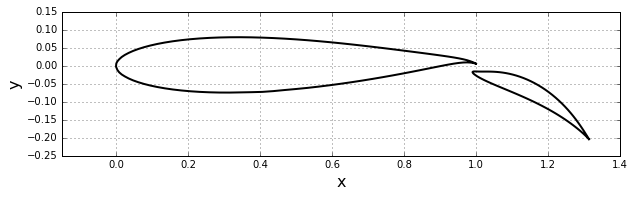

In [44]:
#plot airfoil 
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.15, 1.4)
pyplot.ylim(-0.25,0.15)

In [45]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
        
        self.xa, self.ya = xa, ya #panel start 
        self.xb, self.yb = xb, yb #panel end
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2 #panel center 
        self.length = numpy.sqrt((xb-xa)**2 + (yb-ya)**2) #panel length
        
        #angle between x axis and panel's normal - orientation 
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
            
        #panel location 
        if self.beta <= numpy.pi:
            self.loc = 'upper' #upper surface
        else:
            self.loc = 'lower' #lower surface 
            
        self.sigma = 0.0 #strength of source
        self.vt = 0.0 #tangential velocity 
        self.cp = 0.0 #pressure coeff

In [86]:
def define_panels(x, y, N):
    
    x_ends, y_ends = x, y 
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

In [87]:
Nm = len(x_main)-1
Nf = len(x_flap)-1

panels_main = define_panels(x_main, y_main, Nm)
panels_flap = define_panels(x_flap, y_flap, Nf)

panels = numpy.concatenate((panels_main, panels_flap))

(-0.25, 0.15)

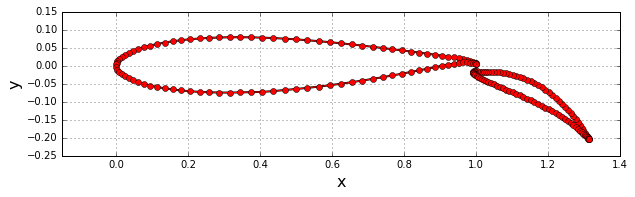

In [88]:
width=10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)

pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2)

pyplot.plot(numpy.append([panel.xa for panel in panels_main], panels_main[0].xa), 
           numpy.append([panel.ya for panel in panels_main], panels_main[0].ya), 
           linestyle='-', linewidth=1, marker='o', markersize=6, color='r')
pyplot.plot(numpy.append([panel.xa for panel in panels_flap], panels_flap[0].xa), 
           numpy.append([panel.ya for panel in panels_flap], panels_flap[0].ya), 
           linestyle='-', linewidth=1, marker='o', markersize=6, color='r')

pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.15, 1.4)
pyplot.ylim(-0.25,0.15)

In [ ]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

In [ ]:
u_inf = 1.0
alpha = 0.0 
freestream = Freestream(u_inf, alpha)

In [89]:
def integral(x, y, panel, dxdk, dydk):
    
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(lambda s: integrand(s), 0.0, panel.length)[0]

In [90]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    N = len(panels)
    A = numpy.empty((N,N), dtype=float)
    numpy.fill_diagonal(A, 0.5)

    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))

    return A

In [91]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    N = len(panels)
    A = numpy.empty((N,N), dtype=float)
    numpy.fill_diagonal(A, 0.0)

    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))

    return A

In [92]:
def matrix(panels):
    """Build matrix of linear system including kutta condition
    """
    
    N = len(panels)
    
    #vortex 
    vc = numpy.empty((N, 2), dtype=float)
    
    #source
    sc1 = numpy.zeros((N), dtype=float)
    sc2 = numpy.zeros((N), dtype=float)
    
    #kutta
    kc = numpy.empty((2, N+2), dtype=float)
    
    #matrix
    a = numpy.zeros((N, N+2), dtype=float)
    A = numpy.empty((N+2, N+2), dtype=float)
    
    a_source = source_contribution_normal(panels)
    b_vortex = vortex_contribution_normal(panels)
    
    for i, panel_i in enumerate(panels):
        vc[i,0] = numpy.sum(b_vortex[i, :(N/2)])
        vc[i,1] = numpy.sum(b_vortex[i, (N/2):])
    
    for i, panel_i in enumerate(panels):
        sc1[i] = numpy.sum(a_source[i, :(N/2)])
        sc2[i] = numpy.sum(a_source[i, (N/2):])
        
    a[:N,:N] = b_vortex
    a[:,-2], a[:,-1] = -sc1, -sc2
    
    kc[0,:] = a[0,:] + a[(N/2)-1,:]
    kc[1,:] = a[(N/2),:] + a[-1,:]
    
    A[0:N,0:N] = a_source
    A[0:N,N:] = vc
    A[N:,:] = kc
    
    return A, a

In [93]:
A, a = matrix(panels)

/Users/alexabaumer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/alexabaumer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/alexabaumer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/alexabaumer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/alexabaumer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/alexabau

In [94]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    N = len(panels)
    
    b = numpy.empty(N+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[N] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[(N/2)-1].beta) )
    
    b[N+1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[(N/2)].beta)
                               +numpy.sin(freestream.alpha-panels[N-1].beta) )
  
    return b

In [95]:
b = build_freestream_rhs(panels, freestream)

/Users/alexabaumer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/alexabaumer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [96]:
strengths = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = strengths[i]
    
gamma = strengths[-2:]

In [97]:
def compute_tangential_velocity(panels, freestream, gamma, A):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    """ 
    N = len(panels)
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
      
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [98]:
compute_tangential_velocity(panels, freestream, gamma, a)

In [99]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [100]:
# surface pressure coefficient
compute_pressure_coefficient(panels, freestream)

In [101]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels])
print(accuracy)

[-0.00174836]


In [102]:
lift, drag = 0.0, 0.0

for panel in panels:
    lift -= panel.cp*panel.length*math.sin(panel.beta)
    drag += sum(panel.cp*panel.length*math.cos(panel.beta))/len(panels)
    
print(lift)
print(drag)

[  0.90426217   1.72254242   2.44328464   3.01822085   3.35714259
   3.49070613   3.49142472   3.41631885   3.31084117   3.20655047
   3.11458835   3.04168208   2.98693842   2.95000754   2.92937679
   2.92393341   2.93210711   2.95131184   2.97967164   3.01636633
   3.06169712   3.11595268   3.17713474   3.24385317   3.31717289
   3.39752271   3.48450079   3.57792168   3.67830664   3.78721697
   3.90518345   4.03196557   4.16952754   4.32040105   4.4861359
   4.6702132    4.87741702   5.11021696   5.37574704   5.68576144
   6.04594048   6.4730211    6.99864118   7.61920152   8.37402065
   9.445902    10.65004612  11.84266091  13.58907196  14.5001696
  14.39557322  12.7043685   10.56923314   8.90683491   7.3898464
   6.33803638   5.43433662   4.71632975   4.16581803   3.70482328
   3.32639166   3.01808838   2.76040708   2.5461968    2.36889407
   2.22117906   2.10056781   2.0045664    1.92072157   1.85906033
   1.84523053   1.78993209   1.68695063   1.70769915   1.7804832
   1.77810605 

In [103]:
sum(panels[2].cp)/len(panels)

-1.8072897822940428

## Part 2

In [70]:
#load main airfoil geometry
with open ('NACA23012_MainFoil.csv') as infile:
    airfoil_main = numpy.loadtxt(infile, dtype=float, delimiter=',')
    
x_main = numpy.empty((len(airfoil_main),1))
y_main = numpy.empty((len(airfoil_main),1))

for i in range(0, len(airfoil_main)):
    x_main[i] = airfoil_main[i, 0]
    y_main[i] = airfoil_main[i, 1]
    
#load flap geometry 
with open ('NACA23012_FlapFoil.csv') as infile:
    airfoil_flap = numpy.loadtxt(infile, dtype=float, delimiter=',')
    
x_flap = numpy.empty((len(airfoil_flap),1))
y_flap = numpy.empty((len(airfoil_flap),1))

for i in range(0, len(airfoil_flap)):
    x_flap[i] = airfoil_flap[i, 0]
    y_flap[i] = airfoil_flap[i, 1]

(-0.07, 0.09)

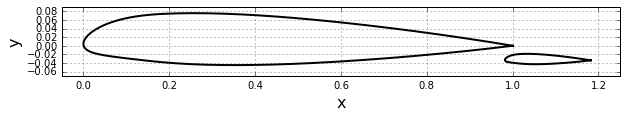

In [71]:
#plot airfoil 
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.05, 1.25)
pyplot.ylim(-0.07,0.09)

In [72]:
def rotate_flap(x_flap, y_flap, xc, yc, theta):
    
    theta = theta * numpy.pi / 180
    
    x = x_flap - xc
    y = y_flap - yc
    
    xn = (x*numpy.cos(theta) + y*numpy.sin(theta)) + xc
    yn = (-x*numpy.sin(theta) + y*numpy.cos(theta)) + yc
    
    return xn, yn

In [77]:
#Rotate flap 
xc = 1.03 
yc = -0.054
theta = 20.0
xn, yn = rotate_flap(x_flap, y_flap, xc, yc, theta)

In [80]:
Nm = len(x_main)-1
Nf = len(x_flap)-1

panels_main = define_panels(x_main, y_main, Nm)
panels_flap = define_panels(xn, yn, Nf)
panels = numpy.append(panels_main, panels_flap)

(-0.25, 0.15)

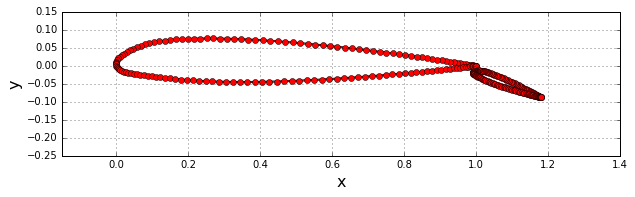

In [82]:
width=10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)

pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(xn, yn, color='k', linestyle='-', linewidth=2)

pyplot.plot(numpy.append([panel.xa for panel in panels_main], panels_main[0].xa), 
           numpy.append([panel.ya for panel in panels_main], panels_main[0].ya), 
           linestyle='-', linewidth=1, marker='o', markersize=6, color='r')
pyplot.plot(numpy.append([panel.xa for panel in panels_flap], panels_flap[0].xa), 
           numpy.append([panel.ya for panel in panels_flap], panels_flap[0].ya), 
           linestyle='-', linewidth=1, marker='o', markersize=6, color='r')

pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.15, 1.4)
pyplot.ylim(-0.25,0.15)

In [73]:
def bisection():
    

In [ ]:
#use bisection method to determine the angle of attack that will cause zero lift 
#when the flap angle is 20 degrees